# Regression

Regression is a **supervised** machine learning technique for predicting a **continuous** target variable. 

## Common Regression Algorithms

Overview of the most common regression algorithms, along with their scikit-learn implementation. 


### Ordinary Least Squares

The linear regression algorithm we have all grown to know and love. In sklearn, the method that runs the OLS algorithm is [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression).  

> `sklearn.linear_model.LinearRegression()`

### LASSO + LARS

Performs both feature selection and noise reduction to avoid overfitting (through Regularization$^{1}$) to improve prediction performance and interpretability. Y should be normally distributed. The method to run the Lasso Lars combination in sklearn is [LassoLars](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoLars.html).  

LASSO = Least Absolute Shrinkage and Selection Operator

LARS = Least Angle Regression


> `sklearn.linear_model.LassoLars(alpha=1.0)`  

About alpha

- $\alpha = 0$ is basically the OLS algorithm.

- $\alpha \in [0,\infty]$

- Higher $\alpha$ will be more robust to collinearity between features.

- As $\alpha$ increases, it will reach a point where performance in the model no longer changes. The fewer the features, the lower the value of $\alpha$ will be when you reach that point.

- $\alpha = 1$ is a good starting point.   

- This is NOT the same $\alpha$ as the one representing critical value in statistical tests!  

### Polynomial Regression

Just like an ordinary linear model, but where the features are polynomial. So we create polynomial features first using the [PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html#sklearn.preprocessing.PolynomialFeatures.fit_transform) method, and then fit a model using our new transformed features using any of the linear models, such as [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression)  

Steps:

1. Transform the features, with the hyperparameter `degree` representing the expected shape of the relationship between the features (X) and the target variable (y). It will usually be a 2 or 3, meaning a 2nd or 3rd degree polynomial. Values over that are likely to lead to overfitting.

> `sklearn.preprocessing.PolynomialFeatures(degree=2)` 

2. Fit a regression model using the transformed features. 

> `sklearn.linear_model.LinearRegression()`

### Generalized Linear Model

The most flexible regression algorithm, the GLM allows for different distributions, beyond just the Normal Distribution for OLS (and other models based on OLS, like LASSO). We will use the [TweedieRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.TweedieRegressor.html)$^{2}$ method to create a GLM using sklearn.   

> `sklearn.linear_model.TweedieRegressor(power=0, alpha=1.0)`  

About power

- power = 0: Normal Distribution  

- power = 1: Poisson Distribution  

- power = (1,2): Compound Distribution  

- power = 2: Gamma Distribution  

- power = 3: Inverse Gaussian Distribution  

_________________________

**TL;DR**

First of all, it always helps to know the distribution of your target variable before modeling. 

> plt.hist(y_train) to see the shape of your target (y).  

Secondly, you could try them all...doesn't hurt usually.  

Third, if you have a good feel for your data: 

- For a normally distributed y and a linear relationship: OLS, LassoLars, GLM(power=0) will work best.   

- For polynomial relationships, polynomial regression is best.   

- For poisson, gamma or inverse gaussian distributions, use the Generalize Linear Model.   


## Prepare Data for Modeling

**Wrangle and Preprocess**

1. Acquired data from student-mat.csv. 

1. Split data 

1. Encode variables

1. Scale data

`wrangle.wrangle_sutdent_math(path)` returns the following: 

| Variable | Object Returned | Description | Purpose |
|:-|:-|:-|:-|
| 1. df | dataframe | Original, complete dataframe | Acquire and prepare |
| 2. X_train_exp | dataframe | Features only, Unscaled | Exploration & analysis     |
| 3. X_train | dataframe | Features only, Scaled, Encoded categorical variables | Feature selection, fit models, make predictions |
| 4. y_train | series | Target variable only, Unscaled | Feature selection, evaluate model predictions |
| 5. X_validate | dataframe | Features only, Scaled, Encoded categorical variables | Make predictions using top models |
| 6. y_validate | series | Target variable only, Unscaled | Evaluate model predictions made from X_validate to assess overfitting | 
| 7. X_test | dataframe | Features only, Scaled, Encoded categorical variables | Make predictions using best model|
| 8. y_test | series | Target variable only, Unscaled | Evaluate model predictions made from X_test to estimate future performance on new data |

In [2]:
import pandas as pd
import numpy as np
import wrangle
import matplotlib.pyplot as plt

# modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

import warnings
warnings.filterwarnings("ignore")

path='https://gist.githubusercontent.com/ryanorsinger/\
55ccfd2f7820af169baea5aad3a9c60d/raw/da6c5a33307ed7ee207bd119d3361062a1d1c07e/student-mat.csv'

df, X_train_exp, X_train, y_train, \
    X_validate, y_validate, \
    X_test, y_test = wrangle.wrangle_student_math(path)

**Target Variable/y**

This helps us determine which type of algorithm we may want to use. 

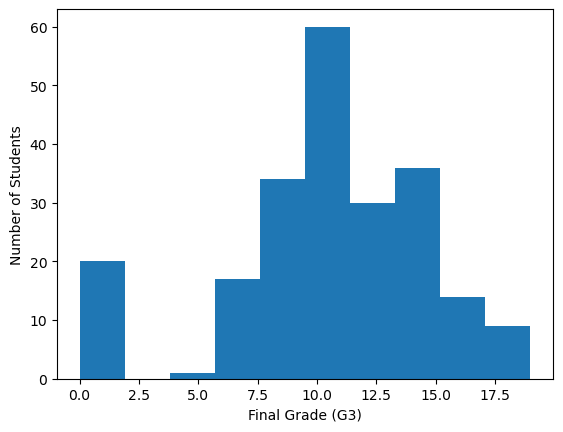

In [7]:
plt.hist(y_train)
plt.xlabel("Final Grade (G3)")
plt.ylabel("Number of Students")
plt.show()

## Modeling

### Baseline

About the initial baseline: 

> Before we begin making models, we need to know how well we can estimate (predict) the final grade (G3) without using any features. This is often done by predicting every observation's target value to be the mean or the median. E.g. we could predict every student's final grade to be the mean final grade of all the students in our training sample. We will try both the mean and the median, see which performs best, and set that evaluation metric value as our baseline performance to beat. 


1. Predict all final grades to be 10.52, which is equal to the mean of G3 for the training sample. Store in `y_train['G3_pred_mean']`. 

2. Predict all final grades to be 11, which is equal to the median of G3 for the training sample. Store in `y_train['G3_pred_median']`.  

3. Compute the RMSE comparing actual final grade (G3) to G3_pred_mean. 

4. Compute the RMSE comparing actual final grade (G3) to G3_pred_median. 

In [8]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# 1. Predict G3_pred_mean
G3_pred_mean = y_train['G3'].mean()
y_train['G3_pred_mean'] = G3_pred_mean
y_validate['G3_pred_mean'] = G3_pred_mean

# 2. compute G3_pred_median
G3_pred_median = y_train['G3'].median()
y_train['G3_pred_median'] = G3_pred_median
y_validate['G3_pred_median'] = G3_pred_median

# 3. RMSE of G3_pred_mean
rmse_train = mean_squared_error(y_train.G3, y_train.G3_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.G3, y_validate.G3_pred_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# 4. RMSE of G3_pred_median
rmse_train = mean_squared_error(y_train.G3, y_train.G3_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.G3, y_validate.G3_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  4.5 
Validate/Out-of-Sample:  4.58
RMSE using Median
Train/In-Sample:  4.52 
Validate/Out-of-Sample:  4.69


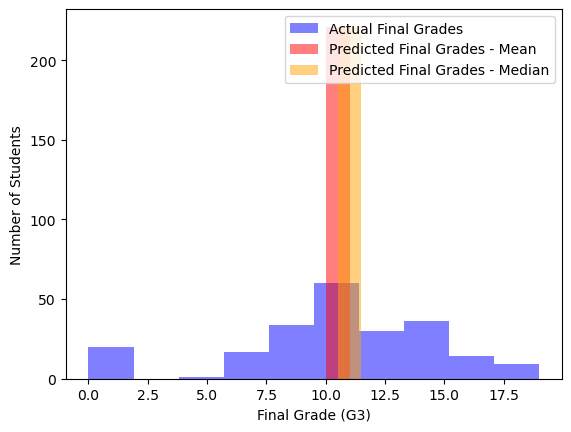

In [9]:
# plot to visualize actual vs predicted. 
plt.hist(y_train.G3, color='blue', alpha=.5, label="Actual Final Grades")
plt.hist(y_train.G3_pred_mean, bins=1, color='red', alpha=.5, rwidth=100, label="Predicted Final Grades - Mean")
plt.hist(y_train.G3_pred_median, bins=1, color='orange', alpha=.5, rwidth=100, label="Predicted Final Grades - Median")
plt.xlabel("Final Grade (G3)")
plt.ylabel("Number of Students")
plt.legend()
plt.show()

### LinearRegression (OLS)

1. Fit the model using X_train_scaled and the labels from y_train. 

2. Predict final grade for students in training sample using our model (lm). 

3. Evaluate using RMSE

4. Repeat predictions and evaluation for validation. 

5. Compare RMSE train vs. validation. Overfitting? 

In [10]:
# create the model object
lm = LinearRegression()

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train, y_train.G3)

# predict train
y_train['G3_pred_lm'] = lm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.G3, y_train.G3_pred_lm)**(1/2)

# predict validate
y_validate['G3_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.G3, y_validate.G3_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  1.6423518638932804 
Validation/Out-of-Sample:  2.3167068610200023


### LassoLars

1. Fit the model using X_train_scaled and the labels from y_train. 

2. Predict final grade for students in training sample using our model (lars). 

3. Evaluate using RMSE

4. Repeat predictions and evaluation for validation. 

5. Compare RMSE train vs. validation. Overfitting? 

In [11]:
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train, y_train.G3)

# predict train
y_train['G3_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.G3, y_train.G3_pred_lars)**(1/2)

# predict validate
y_validate['G3_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.G3, y_validate.G3_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  4.498925523895268 
Validation/Out-of-Sample:  4.578916932633144


### TweedieRegressor (GLM)

1. Fit the model using X_train_scaled and the labels from y_train. 

2. Predict final grade for students in training sample using our model (glm). 

3. Evaluate using RMSE

4. Repeat predictions and evaluation for validation. 

5. Compare RMSE train vs. validation. Overfitting? 

In [12]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.G3)

# predict train
y_train['G3_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.G3, y_train.G3_pred_glm)**(1/2)

# predict validate
y_validate['G3_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.G3, y_validate.G3_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  2.1576940833167058 
Validation/Out-of-Sample:  2.5002918114896353


### Polynomial Regression

Using sklearn.preprocessing.PolynommialFeatures() + sklearn.linear_model.LinearRegression()

1. Create the new features, based on value indicated for degree for train, validate & test. 

2. Fit the Linear Regression model

3. Predict using the transformed (squared or cubed, e.g.) features 

4. Evaluate using RMSE

5. Repeat predictions and evaluation for validation.

6. Compare RMSE train vs. validation. Overfitting?

**PolynomialFeatures**

In [13]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)

**LinearRegression**

In [14]:
# create the model object
lm2 = LinearRegression()

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.G3)

# predict train
y_train['G3_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.G3, y_train.G3_pred_lm2)**(1/2)

# predict validate
y_validate['G3_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.G3, y_validate.G3_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  2.0949158390423483e-14 
Validation/Out-of-Sample:  3.016775612592487


### Evaluate

**Plotting Actual vs. Predicted Values**

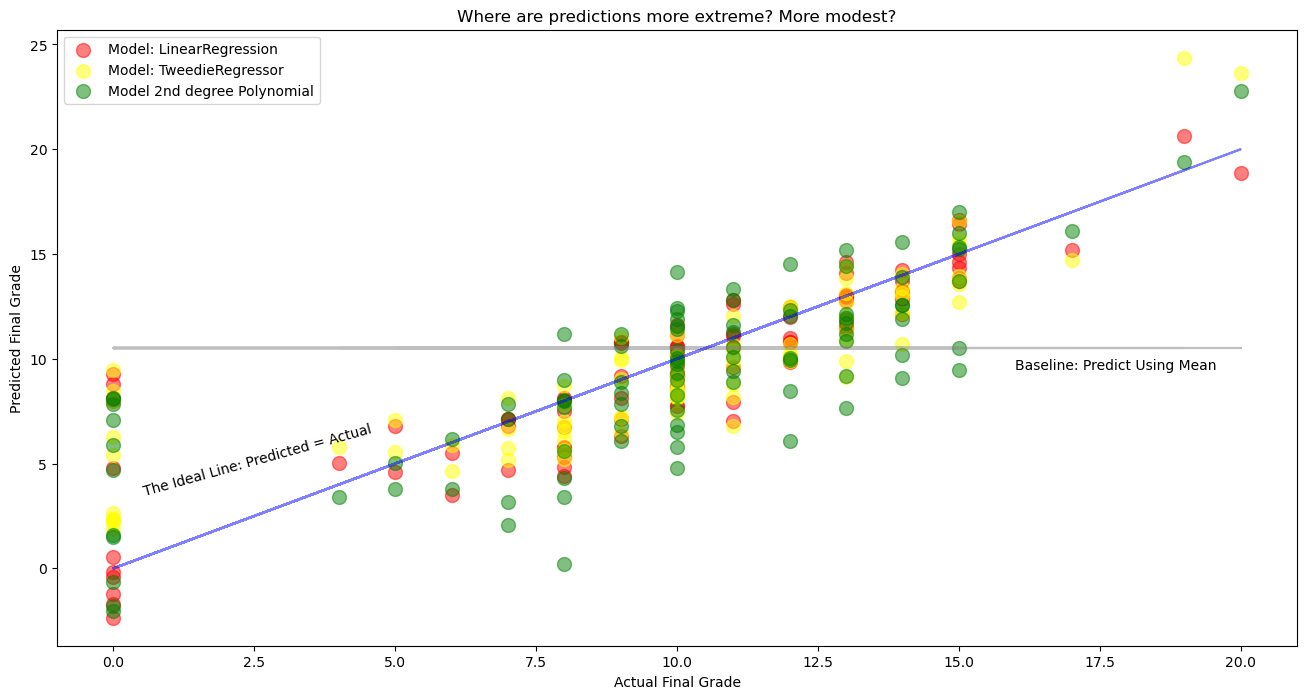

In [15]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate.G3, y_validate.G3_pred_mean, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_validate.G3, y_validate.G3, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_validate.G3, y_validate.G3_pred_lm, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.G3, y_validate.G3_pred_glm, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.G3, y_validate.G3_pred_lm2, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Final Grade")
plt.ylabel("Predicted Final Grade")
plt.title("Where are predictions more extreme? More modest?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

**Residual Plots: Plotting the Errors in Predictions**

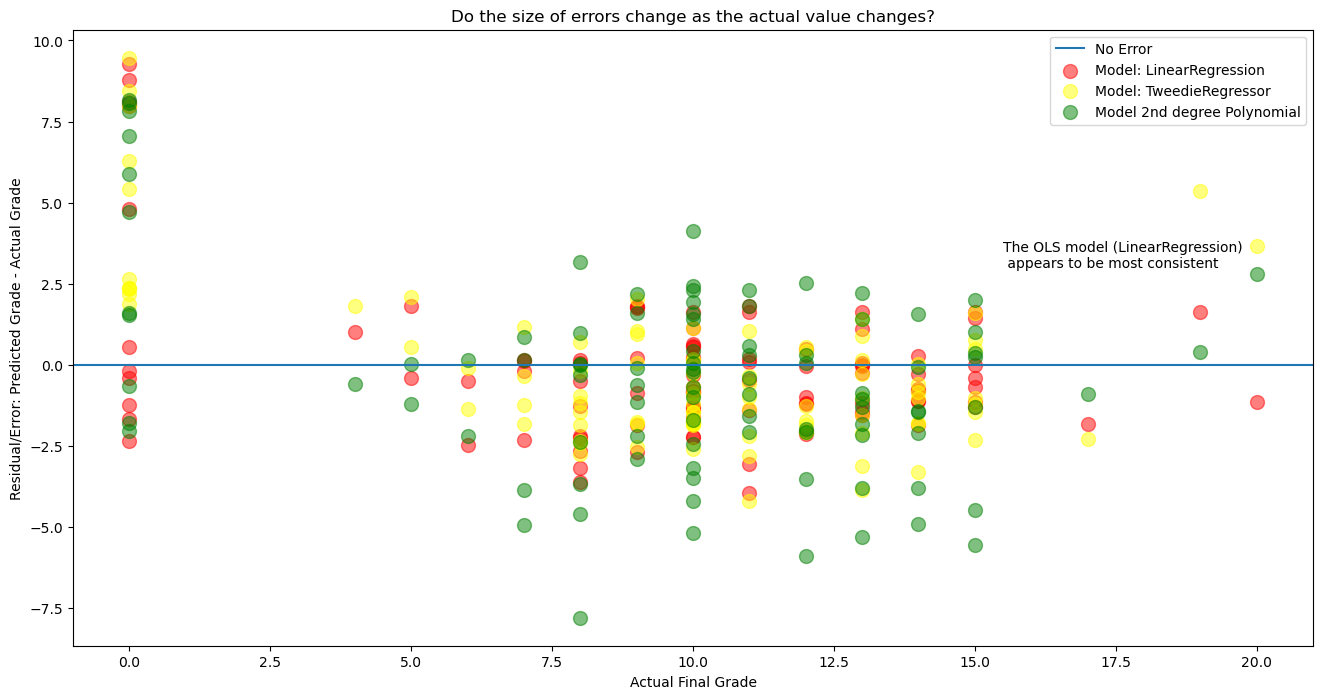

In [16]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.axhline(label="No Error")
plt.scatter(y_validate.G3, y_validate.G3_pred_lm-y_validate.G3, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.G3, y_validate.G3_pred_glm-y_validate.G3, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.G3, y_validate.G3_pred_lm2-y_validate.G3, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Final Grade")
plt.ylabel("Residual/Error: Predicted Grade - Actual Grade")
plt.title("Do the size of errors change as the actual value changes?")
plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

**Histograms**

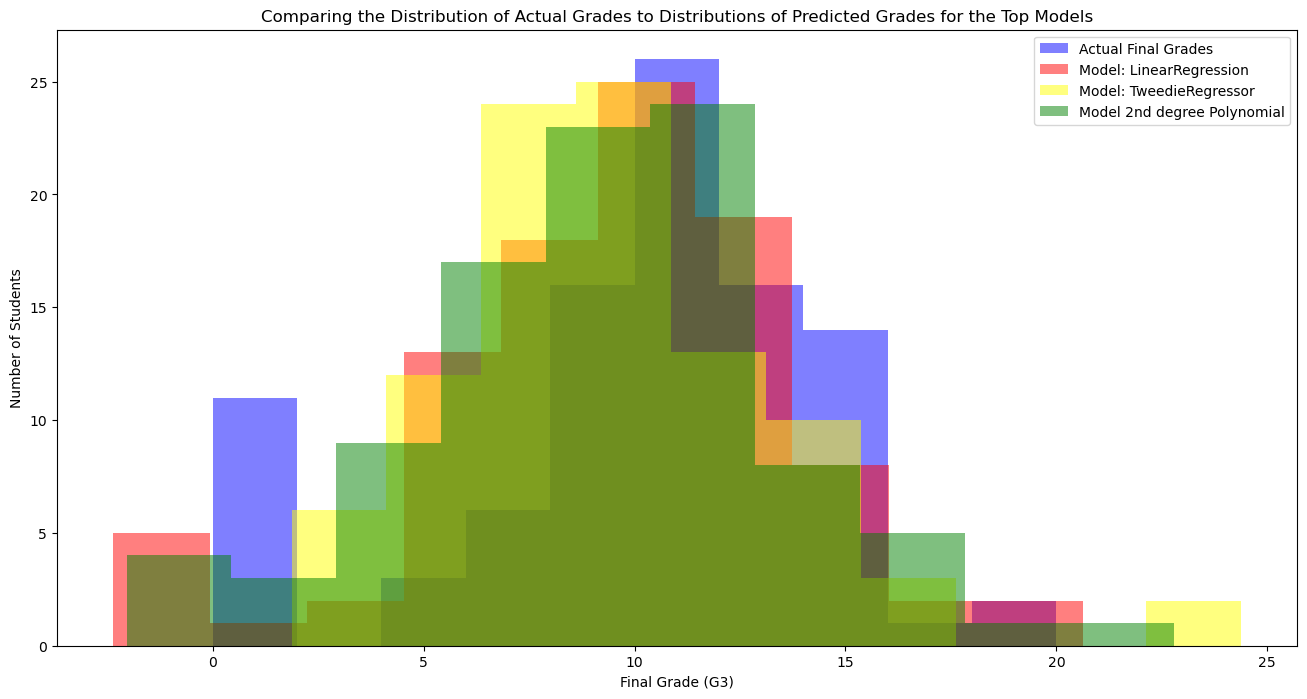

In [17]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(y_validate.G3, color='blue', alpha=.5, label="Actual Final Grades")
plt.hist(y_validate.G3_pred_lm, color='red', alpha=.5, label="Model: LinearRegression")
plt.hist(y_validate.G3_pred_glm, color='yellow', alpha=.5, label="Model: TweedieRegressor")
plt.hist(y_validate.G3_pred_lm2, color='green', alpha=.5, label="Model 2nd degree Polynomial")
plt.xlabel("Final Grade (G3)")
plt.ylabel("Number of Students")
plt.title("Comparing the Distribution of Actual Grades to Distributions of Predicted Grades for the Top Models")
plt.legend()
plt.show()

**Model Selection & Out-of-Sample Evaluation**

Model selected: lm (using LinearRegression)

In [19]:
y_test = pd.DataFrame(y_test)

# predict on test
y_test['G3_pred_lm'] = lm.predict(X_test)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.G3, y_test.G3_pred_lm)**(1/2)

print("RMSE for OLS Model using LinearRegression\nOut-of-Sample Performance: ", rmse_test)

RMSE for OLS Model using LinearRegression
Out-of-Sample Performance:  2.078371913347772


### Exercises

Do your work for this exercise in a jupyter notebook named `modeling` within the `regression-exercises` repo. Add, commit, and push your work.

1. Select a dataset with a continuous target variable.   

2. Be sure your data is prepared (no missing values, numeric datatypes) and split into samples. 

3. Work through **all** of the steps outlined in the lesson, from setting the baseline to selected a model and evaluating the final model on your test data. 


### Notes

$^{1}$ Regularization = "Regularizations are techniques used to reduce the error by fitting a function appropriately on the given training set and avoid overfitting." [Towards Data Science](https://towardsdatascience.com/regularization-an-important-concept-in-machine-learning-5891628907ea)

$^{2}$ TweedieRegressor: Requires sklearn v0.23 or greater installed. To update, run in terminal: `conda install scikit-learn=0.23`